In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.feature_column as fc 
import tensorflow.debugging as tfdbg
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/train.flat.csv", dtype={'fullVisitorId': 'str', 'visitId': 'str'})
df_t = pd.read_csv("data/test.flat.csv", dtype={'fullVisitorId': 'str', 'visitId': 'str'})
for col in df.columns:
#     print(col, df[col].fillna('').nunique())
    if df[col].fillna('').nunique() == 1:
        print("column skipped (cardinality = 1):", col)
        df = df.drop(col, axis=1)

column skipped (cardinality = 1): device.mobileDeviceInfo
column skipped (cardinality = 1): device.browserVersion
column skipped (cardinality = 1): totals.visits
column skipped (cardinality = 1): geoNetwork.networkLocation
column skipped (cardinality = 1): device.screenResolution
column skipped (cardinality = 1): geoNetwork.longitude
column skipped (cardinality = 1): geoNetwork.latitude
column skipped (cardinality = 1): device.flashVersion
column skipped (cardinality = 1): device.language
column skipped (cardinality = 1): trafficSource.adwordsClickInfo.criteriaParameters
column skipped (cardinality = 1): device.screenColors
column skipped (cardinality = 1): device.mobileDeviceModel
column skipped (cardinality = 1): socialEngagementType
column skipped (cardinality = 1): device.operatingSystemVersion
column skipped (cardinality = 1): device.mobileInputSelector
column skipped (cardinality = 1): device.mobileDeviceBranding
column skipped (cardinality = 1): geoNetwork.cityId
column skipped 

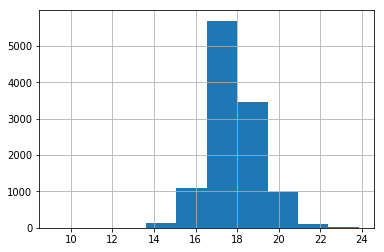

In [2]:
(np.log(df['totals.transactionRevenue'].dropna() +1)).hist()

In [3]:
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0)

In [4]:
sdf = pd.DataFrame()
sdf_t = pd.DataFrame()
features = []

# boolean
for col in ['trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd', 'device.isMobile', 'totals.newVisits']:
    sdf[col] = df[col].apply(lambda x: 2 if np.isnan(x) else int(x))
    sdf_t[col] = df_t[col].apply(lambda x: 2 if np.isnan(x) else int(x))
    features.append(fc.indicator_column(fc.categorical_column_with_vocabulary_list(col, (0,1,2))))
        
# numeric
for col in ['visitNumber', 'visitStartTime', 'date', 'totals.hits', 'totals.pageviews']:
    minv = df[col].min()
    maxv = df[col].max()
    sdf[col] = df[col].apply(lambda x: (x-minv)/maxv).fillna(0)
    sdf_t[col] = df_t[col].apply(lambda x: (x-minv)/maxv).fillna(0)
    features.append(fc.numeric_column(col))

    
from sklearn.preprocessing import LabelEncoder
    
# string
for col in [
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.page',
    'channelGrouping',
    'geoNetwork.region',
    'geoNetwork.country',
    'geoNetwork.metro',
    'trafficSource.campaign',
    'totals.bounces',
    #'trafficSource.referralPath',
    'device.deviceCategory',
    'device.browser',
    'trafficSource.adContent',
    'trafficSource.medium',
    'geoNetwork.city',
    'trafficSource.source',
    'trafficSource.adwordsClickInfo.slot',
    'fullVisitorId',
    'geoNetwork.subContinent',
    'device.operatingSystem',
    #'geoNetwork.networkDomain',
    'trafficSource.adwordsClickInfo.gclId',
#     'trafficSource.campaignCode', // not exist in test
    'trafficSource.keyword',
    'geoNetwork.continent']:
    le = LabelEncoder()
    le.fit(pd.concat([df[col].astype(str).fillna(''), df_t[col].astype(str).fillna('')]))
    sdf[col] = le.transform(df[col].astype(str).fillna(''))
    sdf_t[col] = le.transform(df_t[col].astype(str).fillna(''))

In [5]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

label = pd.to_numeric(df['totals.transactionRevenue'] >0)

In [38]:
import xgboost as xgb
# from sklearn.grid_search import GridSearchCV

clf_xgb = xgb.XGBClassifier(max_depth=6, n_jobs=8, objective='binary:logistic', reg_alpha=2)
X_train, X_test, y_train, y_test = train_test_split(sdf, label, test_size=.2, random_state=10)

In [39]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

accuracy: 0.9885077822841681
[[178145    312]
 [  1765    509]]
(180731, 2)
<bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>


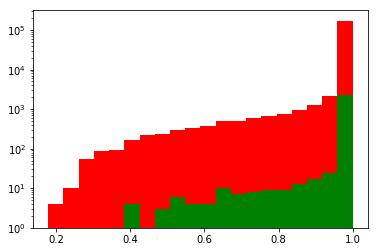

In [40]:
pred = clf_xgb.predict_proba(X_test)
cv = pd.DataFrame(pred[:,0])[df['totals.transactionRevenue'] >0][0]
# cv
non_cv = pd.DataFrame(pred[:,0])[df['totals.transactionRevenue'] == 0][0]
plt.hist([cv, non_cv], stacked=['True'], color=['g', 'r'], log=True, bins=20)
print('accuracy:', clf_xgb.score(X_test, y_test))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, clf_xgb.predict(X_test)))
print(pred.shape)
print(clf_xgb.score)

In [41]:
from xgboost import plot_tree
graph1 = xgb.to_graphviz(clf_xgb)
graph1.format = 'png'
graph1.render('data/tree')

'data/tree.png'

In [42]:
proba = clf_xgb.predict_proba(sdf)[:,0]
sdf_cv = sdf.copy()
sdf_cv['cv_prob'] = proba
revenue = np.log(df['totals.transactionRevenue'] +1)

In [43]:
from sklearn.metrics import mean_squared_error
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [50]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(sdf_cv, revenue, test_size=.2, random_state=10)
clf = linear_model.Lasso(alpha=0.00005)
clf.fit(X_train, y_train)
print(clf.coef_) 
y_pred = clf.predict(X_test)
print('RMSE:', RMSE(y_pred, y_test))

[ 3.18249436e-02  0.00000000e+00  1.32752080e-02  3.28560458e-03
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.01055464e+01
  7.78948764e+00  0.00000000e+00  8.84318803e-03  1.80416860e-02
  1.47627667e-05 -1.02543718e-04 -1.34297942e-04  1.83987962e-03
  2.90011404e-04 -3.01256291e-03 -8.28952413e-05  1.03053353e-03
 -2.27565302e-02  1.36912932e-05  9.50580899e-06 -0.00000000e+00
 -1.73682828e-09  9.35410187e-05  2.11035494e-04 -9.08021739e-07
 -1.15823261e-05  7.54568381e-03 -2.01105805e+01]
RMSE: 1.6109642765991907


In [51]:
sdf_t_cv = sdf_t.copy()
sdf_t_cv['cv_prob'] = clf_xgb.predict_proba(sdf_t)[:,0]

(804684, 31)
(804684,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131e09748>]],
      dtype=object)

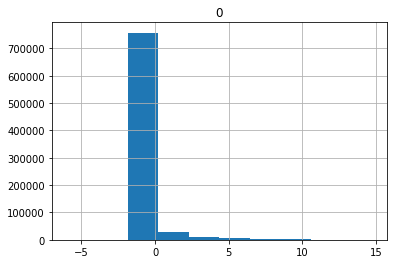

In [52]:
print(sdf_t_cv.shape)
pre = clf.predict(sdf_t_cv)
print(pre.shape)
# print('RMSE:', RMSE(revenue, pre))
pd.DataFrame(pre).hist()

(617242, 2)


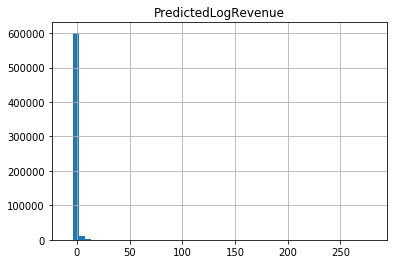

In [53]:
ans = pd.DataFrame()
ans['fullVisitorId'] = df_t['fullVisitorId'].astype(str)
ans['PredictedLogRevenue'] = pre
ans = ans.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
ans.columns = ["fullVisitorId", "PredictedLogRevenue"]
# ans['PredictedLogRevenue'] = np.log(ans['PredictedLogRevenue'])
ans.to_csv('data/xgb+lasso.csv', index=False)
ans.hist(bins=50)
print(ans.shape) 